In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"
os.environ["DDE_BACKEND"] = 'pytorch'
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


In [2]:
geom = dde.geometry.TimeDomain(0, 10)

In [3]:
def ode_system(x, y):
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]

In [4]:
def boundary(_, on_initial):
    return on_initial

In [5]:
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)

In [6]:
def func(x):
    return np.hstack((np.sin(x), np.cos(x)))

In [7]:
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

In [8]:
layer_size = [1] + [50]*3 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

In [9]:
model = dde.Model(data, net)
model.compile('adam', lr=0.001, metrics=['l2 relative error'])

Compiling model...
'compile' took 0.000148 s



In [10]:
losshistory, train_state = model.train(iterations=20000)

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [8.48e-03, 1.07e-02, 0.00e+00, 1.00e+00]    [8.09e-03, 9.56e-03, 0.00e+00, 1.00e+00]    [1.01e+00]    
1000      [8.62e-03, 7.10e-03, 1.20e-08, 3.03e-04]    [9.70e-03, 7.08e-03, 1.20e-08, 3.03e-04]    [7.78e-01]    
2000      [6.33e-03, 4.96e-03, 7.19e-08, 1.69e-04]    [6.81e-03, 5.15e-03, 7.19e-08, 1.69e-04]    [6.72e-01]    
3000      [4.71e-03, 4.41e-03, 5.69e-07, 1.18e-04]    [5.03e-03, 4.70e-03, 5.69e-07, 1.18e-04]    [5.92e-01]    
4000      [3.30e-03, 3.85e-03, 3.73e-07, 7.61e-05]    [3.45e-03, 4.08e-03, 3.73e-07, 7.61e-05]    [4.98e-01]    
5000      [1.60e-03, 2.04e-03, 8.34e-07, 3.01e-05]    [1.69e-03, 1.94e-03, 8.34e-07, 3.01e-05]    [3.29e-01]    
6000      [4.51e-04, 6.30e-04, 1.36e-06, 4.52e-06]    [5.05e-04, 4.43e-04, 1.36e-06, 4.52e-06]    [1.45e-01]    
7000      [1.06e-04, 1.64e-04, 8.58e-07, 1.49e-07]    [9.79e-05, 9.71e-05, 8.

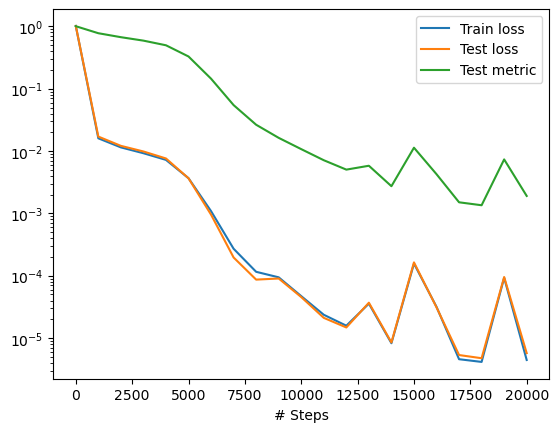

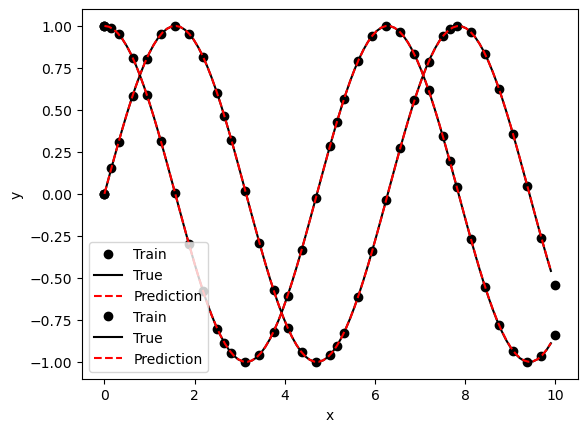

In [11]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [17]:
n = 2
precision_train = 10
precision_test = 30
hard_constraint = True 
weights = 100

In [18]:
iterations = 5000
parameters = [1e-3, 3, 150, 'sin']

sin = dde.backend.pytorch.sin 

learning_rate, num_dense_layers, num_dense_nodes, activation = parameters

In [19]:
geom = dde.geometry.Rectangle([0, 0], [1, 1])
k0 = 2*np.pi*n 
wave_len = 1/n

hx_train = wave_len / precision_train 
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

if hard_constraint == True:
    bc = []
else:
    bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary)

In [20]:
def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = k0 ** 2 * sin(k0*x[:, 0:1])*sin(k0*x[:, 1:2]) 
    return -dy_xx - dy_yy - k0**2 * y - f

In [21]:
def func(x):
    return np.sin(k0*x[:, 0:1])*np.sin(k0*x[:, 1:2])

def transform(x, y):
    res = x[:, 0:1]*(1-x[:, 0:1])*x[:, 1:2]*(1-x[:, 1:2])
    return res*y

def boundary(_, on_boundary):
    return on_boundary

In [22]:
data = dde.data.PDE(
    geom,
    pde,
    bc,
    num_domain=nx_train ** 2,
    num_boundary=4 * nx_train,
    solution=func,
    num_test=nx_test ** 2,
)

In [23]:
net = dde.nn.FNN(
  [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

In [24]:
if hard_constraint == True:
    net.apply_output_transform(transform)

In [25]:
model = dde.Model(data, net)

if hard_constraint == True:
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
else:
    loss_weights = [1, weights]
    model.compile(
        "adam",
        lr=learning_rate,
        metrics=["l2 relative error"],
        loss_weights=loss_weights,
    )

Compiling model...
'compile' took 0.000146 s



In [26]:
losshistory, train_state = model.train(iterations=iterations)

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [4.84e+01]    [5.83e+01]    [3.05e-01]    
2000      [2.67e+00]    [3.13e+00]    [5.92e-02]    
3000      [3.42e-01]    [3.85e-01]    [1.55e-02]    
4000      [5.28e-01]    [5.60e-01]    [1.54e-02]    
5000      [1.00e-01]    [1.06e-01]    [7.11e-03]    

Best model at step 5000:
  train loss: 1.00e-01
  test loss: 1.06e-01
  test metric: [7.11e-03]

'train' took 39.957996 s



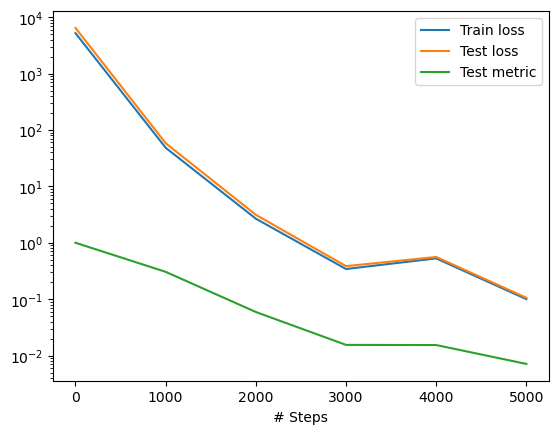

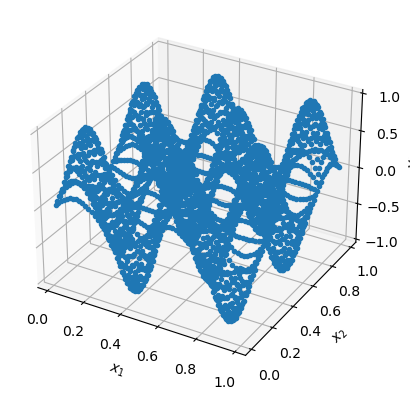

In [35]:
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [53]:
import torch 
import matplotlib.pyplot as plt 

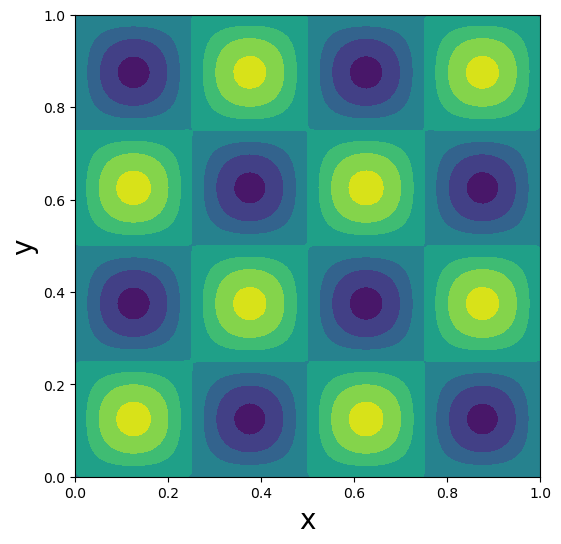

In [70]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_test = torch.linspace(0, 1, 100).to(device)
y_test = torch.linspace(0, 1, 100).to(device)

X_test, Y_test = torch.meshgrid(x_test, y_test)

u_test = net(torch.hstack([X_test.reshape(-1, 1), Y_test.reshape(-1, 1)]))

X_test_numpy = X_test.detach().cpu().numpy()
Y_test_numpy = Y_test.detach().cpu().numpy()
u_test_numpy = u_test.detach().cpu().numpy().reshape(100, 100)

fig, ax = plt.subplots(figsize=(6,6))
cp = ax.contourf(X_test_numpy, Y_test_numpy, u_test_numpy, cmap='viridis')
# fig.colorbar(cp)
ax.set_xlabel('x', fontsize=20)
ax.set_ylabel('y', fontsize=20)
plt.show()

In [71]:
import deepxde as dde
from matplotlib import pyplot as plt
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
elif dde.backend.backend_name == "paddle":
    sin = dde.backend.paddle.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

# General parameters
d = 2
n = 2
k0 = 2 * np.pi * n
precision_train = 10
precision_test = 30
epochs = 10000


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = (d - 1) * k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f


def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def transform(x, y):
    res = x[:, 0:1] * (1 - x[:, 0:1]) * x[:, 1:2] * (1 - x[:, 1:2])
    return res * y


def boundary(_, on_boundary):
    return on_boundary


def create_model(config):
    learning_rate, num_dense_layers, num_dense_nodes, activation = config

    geom = dde.geometry.Rectangle([0, 0], [1, 1])
    k0 = 2 * np.pi * n
    wave_len = 1 / n

    hx_train = wave_len / precision_train
    nx_train = int(1 / hx_train)

    hx_test = wave_len / precision_test
    nx_test = int(1 / hx_test)

    data = dde.data.PDE(
        geom,
        pde,
        [],
        num_domain=nx_train**d,
        num_boundary=2 * d * nx_train,
        solution=func,
        num_test=nx_test**d,
    )

    net = dde.maps.FNN(
        [d] + [num_dense_nodes] * num_dense_layers + [1],
        activation,
        "Glorot uniform",
    )

    net.apply_output_transform(transform)

    model = dde.Model(data, net)
    model.compile("adam", lr=learning_rate, metrics=["l2 relative error"])
    return model


def train_model(model, config):
    losshistory, train_state = model.train(epochs=epochs)
    train = np.array(losshistory.loss_train).sum(axis=1).ravel()
    test = np.array(losshistory.loss_test).sum(axis=1).ravel()
    metric = np.array(losshistory.metrics_test).sum(axis=1).ravel()

    error = test.min()
    return error


# HPO setting
n_calls = 50
dim_learning_rate = Real(low=1e-4, high=5e-2, name="learning_rate", prior="log-uniform")
dim_num_dense_layers = Integer(low=1, high=10, name="num_dense_layers")
dim_num_dense_nodes = Integer(low=5, high=500, name="num_dense_nodes")
dim_activation = Categorical(categories=["sin", "sigmoid", "tanh"], name="activation")

dimensions = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
]

default_parameters = [1e-3, 4, 50, "sin"]


@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers, num_dense_nodes, activation):
    config = [learning_rate, num_dense_layers, num_dense_nodes, activation]
    global ITERATION

    print(ITERATION, "it number")
    # Print the hyper-parameters.
    print("learning rate: {0:.1e}".format(learning_rate))
    print("num_dense_layers:", num_dense_layers)
    print("num_dense_nodes:", num_dense_nodes)
    print("activation:", activation)
    print()

    # Create the neural network with these hyper-parameters.
    model = create_model(config)
    # possibility to change where we save
    error = train_model(model, config)
    # print(accuracy, 'accuracy is')

    if np.isnan(error):
        error = 10**5

    ITERATION += 1
    return error


ITERATION = 0

search_result = gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func="EI",  # Expected Improvement.
    n_calls=n_calls,
    x0=default_parameters,
    random_state=1234,
)

print(search_result.x)

plot_convergence(search_result)
plot_objective(search_result, show_points=True, size=3.8)

0 it number
learning rate: 1.0e-03
num_dense_layers: 4
num_dense_nodes: 50
activation: sin

Compiling model...
'compile' took 0.000082 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.21e+03]    [6.44e+03]    [1.00e+00]    
1000      [2.35e+02]    [3.19e+02]    [5.76e-01]    
2000      [1.12e+02]    [6.72e+02]    [5.70e-01]    
3000      [5.79e+01]    [2.53e+03]    [6.01e-01]    
4000      [3.68e+01]    [3.35e+03]    [6.18e-01]    
5000      [2.91e+01]    [3.57e+03]    [6.27e-01]    
6000      [1.63e+01]    [3.74e+03]    [6.33e-01]    
7000      [1.20e+01]    [3.89e+03]    [6.40e-01]    
8000      [1.45e+01]    [4.17e+03]    [6.52e-01]    
9000      [4.81e+00]    [4.50e+03]    [6.63e-01]    
10000     [1.27e+01]    [4.64e+03]    [6.70e-01]    

Best model at step 9000:
  train loss: 4.81e+00
  test loss: 4.50e+03
  test metric: [6.63e-01]

'train' took 92.533046 s

1 it number
learning rate: 2.2e-03
num_dense_layers: 8
num_dense_nodes: 308
activat

KeyboardInterrupt: 